## Name: Andrew Caide
### CSCI S-89C Deep Reinforcement Learning  
### Part II of Midterm

## Problem 1 (5 points)

In this problem, we consider the optimal selection of a treatment. Suppose that there are 5 types of treatments available. The outcome of each treatment is either 1 (recovery) or 0.   

Let's denote the outcome by $R_t$, then $R_t|(A_t=a)$ follows $\text{Bernoulli}(p_a)$ with $a\in\{1,2,3,4,5\}$ and all $p_a\in [0,1]$, where $A_t$ denotes the action on time step $t=1,2,3,\ldots$. 

Assume that $p_1=0.1$, $p_2=0.3$,  $p_3=0.5$, $p_4=0.7$, $p_5=0.9$, which are not known to the doctor. This is the 5-armed Bandit Problem with Bernoulli distributions. The rewards $R_t$ are 0's and 1's. Please notice that $P\{R_t=1|A_t=a\}=p_a$. Also, the expectation $E\left[R_t|A_t=a \right]=p_a$.

Develop the Optimistic Initial Values algorithm for the problem of selecting the best treatment and report the following graphs:   
(a) Run the algorithm for $t=1,2,3,\ldots,200$ and plot $R_t$'s v.s. $t$ for one simulation.   
(b) Run the trajectory in (a) for 100 epochs; and for each time step $t$ plot the average of $R_t$'s from the epochs at time particular time (please do not average all returns over time - we want to see how the learning progresses over time).   
(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=5$) was selected by the doctor. 

In [4]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

class Environment:
    def __init__(self):
        self.time = 1
        self.p = {1:.1, 2:.3, 3:.5, 4:.7, 5:.9} # <--
        
    def admissible_actions(self):
        return list(range(1,6))
    
    def get_reward(self, action):
        self.time += 1
        return np.random.choice([0,1],1,p=[1-self.p[action],
                                           self.p[action]])[0]

In [5]:
class Agent:
    def __init__(self, e = 0.10):
        self.current_reward = 0.0
        self.current_action = 0
        self.history = pd.DataFrame(columns = ("Action", "Mean_Reward", "Hits")) # <--
        self.history = self.history.set_index("Action") # <--
        self.e = e # <--
        

    # Helper function: update expectation value
    def update_expectation(self, new_reward, index):
        updated_sum = (self.history.loc[index,:].Mean_Reward * self.history.loc[index,:].Hits) +  new_reward
        updated_mean = updated_sum / (self.history.loc[index,:].Hits + 1)
        return updated_mean
        
    # First each state is set to 5
    # The step with the highest Mean Reward is selected with a 90% chance 
    def step(self, env):
        
        # Run once
        actions = env.admissible_actions()
        if len(self.history.index) < len(actions):
            for action in actions:
                self.current_action = int(action)
                self.current_reward = 5 
                self.history.loc[self.current_action,:] = [self.current_reward, 1]
        
        # Roll the dice, check if action has been done
        else:
            roll = random.uniform(0, 1)
            
            # If rolled <10%, randomly do something else
            if roll <= self.e:
                self.current_action = random.choice(actions)
                self.current_reward = env.get_reward(self.current_action)
                
                if self.current_action in self.history.index:
                    new_mean_reward = self.update_expectation(self.current_reward, self.current_action)
                    self.history.loc[self.current_action,:] = [new_mean_reward, self.history.loc[self.current_action,"Hits"]+1]
                else:
                    self.history.loc[self.current_action,:] = [self.current_reward, 1]
            
            # Else, run e-greedy operation 
            else: 
                best_reward_sofar = self.history.Mean_Reward == max(self.history.Mean_Reward)
                self.current_action = self.history[best_reward_sofar].index.values[0]
                self.current_reward = env.get_reward(self.current_action)
                new_mean_reward = self.update_expectation(self.current_reward, self.current_action)
                self.history.loc[self.current_action,:] = [new_mean_reward, self.history.loc[self.current_action,"Hits"]+1]

In [6]:
def complete_hist(T = 10):
    env = Environment()
    agent = Agent()
    behavior = pd.DataFrame(columns = ("Action", "Reward")) # <--
    
    while env.time <= T:
        agent.step(env)
        behavior = behavior.append({"Action":agent.current_action, # <--
                                   "Reward":agent.current_reward},  # <--
                                   ignore_index = True) # <--
    return behavior

---

(a) Run the algorithm for  𝑡=1,2,3,…,200  and plot  𝑅𝑡 's v.s.  𝑡  for one simulation.

No handles with labels found to put in legend.


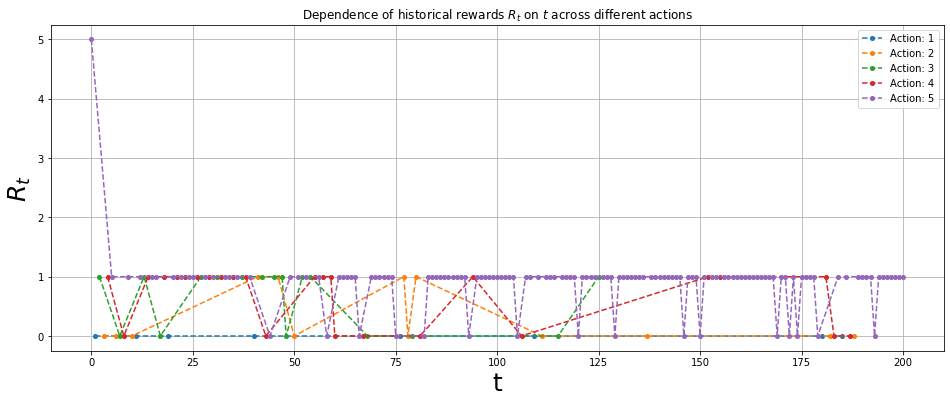

In [7]:
T = 200
performance = complete_hist(T) # <--
groups = performance.groupby('Action') # <--

# Plot
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Dependence of historical rewards $R_t$ on $t$ across different actions')
ax.set_ylabel("$R_t$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)

for name, group in groups:
    ax.plot(group.index, group.Reward, marker='o', linestyle='--', ms=4, label = "Action: {}".format(name))
ax.legend()

plt.show()

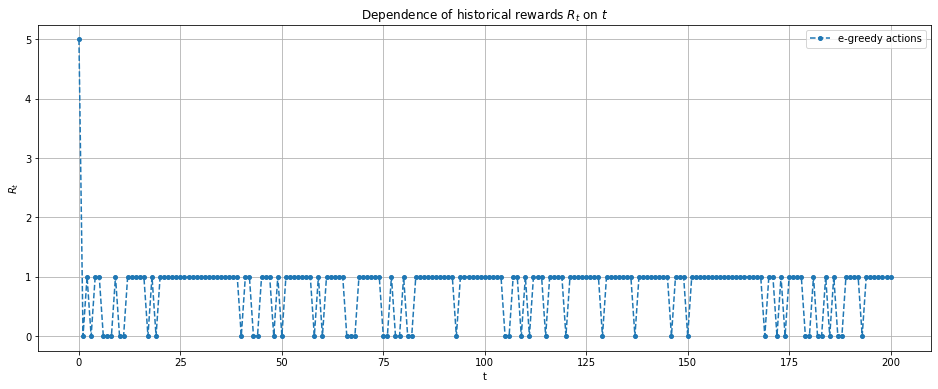

In [8]:
plt.figure(figsize=(16,6))
plt.plot(performance.index, performance.Reward, linestyle='--', marker='o', markersize=4, label='e-greedy actions')
plt.xlabel("t")
plt.ylabel("$R_t$")
plt.title('Dependence of historical rewards $R_t$ on $t$')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

(b) Run the trajectory in (a) for 100 epochs; and for each time step $t$ plot the average of $R_t$'s from the epochs at time particular time (please do not average all returns over time - we want to see how the learning progresses over time).   


In [9]:
def run_e(epochs = 100, T = 200):
    
    epoch_results = pd.DataFrame()
    for epoch in list(range(epochs)):
        run = complete_hist(T)
        run['Epoch'] = epoch
        run['T'] = run.index
        epoch_results = epoch_results.append(run, ignore_index = True)
        if epoch % 25 == 0:
            print("Finished epoch {}".format(epoch))
    return epoch_results
    

In [10]:
p1b = run_e()

Finished epoch 0
Finished epoch 25
Finished epoch 50
Finished epoch 75


In [11]:
p1b['T'] = p1b['T'].astype(int)
p1b['Reward'] = p1b['Reward'].astype(int)

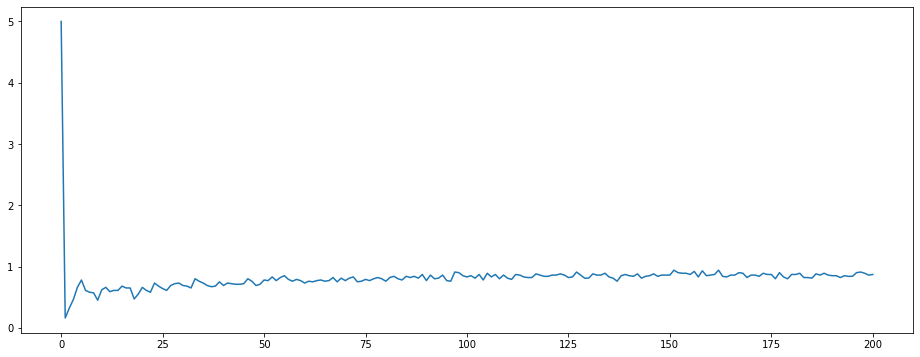

In [12]:
average_reward = p1b.groupby(['T'])['Reward'].mean()
plt.figure(figsize=(16,6))
plt.plot(average_reward.index, average_reward.T)

plt.show()

(c) Using trajectories you obtained in (b), for each time step $t$, plot the proportion  (out of 100) of times the best action (action $a=5$) was selected by the doctor. 

In [13]:
p1c = p1b.groupby(['T','Action']).size().to_frame(name = 'Picks').reset_index()

No handles with labels found to put in legend.


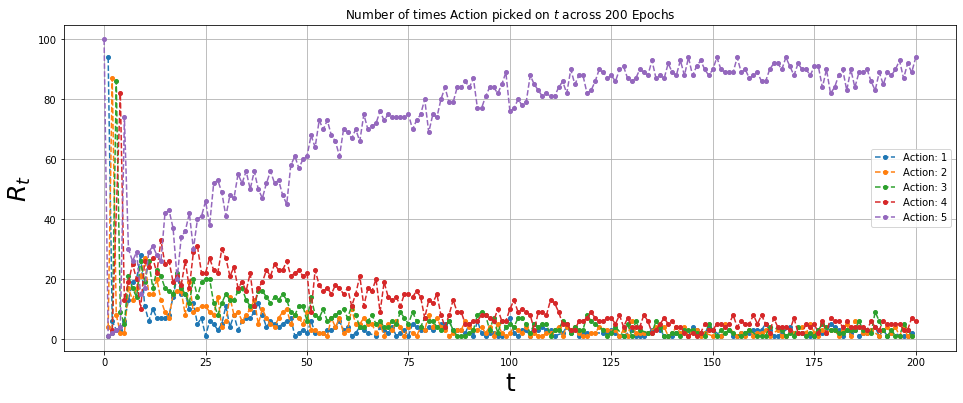

In [14]:
groups = p1c.groupby('Action') # <--

# Plot
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Number of times Action picked on $t$ across 200 Epochs')
ax.set_ylabel("$R_t$",fontsize = 25.0)
ax.set_xlabel("t",fontsize = 25.0)
ax.legend(loc = 'upper right')
ax.grid(True)
for name, group in groups:
    ax.plot(group['T'], group.Picks, marker='o', linestyle='--', ms=4, label = "Action: {}".format(name))
ax.legend()
plt.show()

## Problem 2 (10 points)

In this problem, we consider the optimization of hospital patient flow using the Markov Decision Process. We assume that the hospital can hold 300 patients at most.

Further, we introduce three states as follows:   

"Low" if number of patients is in $[0,100)$   
"Medium" if number of patients is in $[101,200)$   
"High" if number of patients is in $[201,300]$    

Please notice that this aggregation is an improtant step as it allows one to accuratly estimate the transition probabilities from state to state using the database that tracks journeys of patients through the hospital from arrival to discharge.



One time step corresponds to one day and the administration of the hospital can select the following actions:

If the hospital has "Low" number of patients, then $a \in \{0\}$, where $0$ indicates that no patient will be released early.   
If the hospital has "Medium" number of patients, then $a \in \{0,1\}$, i.e. besides action $a=0$, only one additional action is admissible, namely $1$. This action corresponds to releasing $10$ patients early.   
If the hospital has "High" number of patients, then $a \in \{0,1,2\}$, i.e. besides action $a=0$, two additional actions, namely $1$ and $2$, are admissible. Action $a=1$ again corresponds to releasing $10$ patients early, while action $2$ indicates releasing $20$ patients early.  
   
<br>
        
Further, assume that we found the transition probabilities $p(S_{t+1}=s^\prime|S_t=s,A_t=a)$ to be (for a data-driven estimates refer, for instance, to "Markov Decision Process Model for Optimisation of Patient Flow" by Clissold, J. Filar, S. Qin, and D.Ward, 21st International Congress on Modelling and Simulation, Gold Coast, Australia, 29 Nov to 4 Dec 2015):   

$p(S_{t+1}=s^\prime|S_t=s,A_t=0)=\begin{bmatrix} 
0.8 & 0.2 & 0 \\
0.25 & 0.7 & 0.05\\
0.01 & 0.25 & 0.74\\
\end{bmatrix}$    

Here, we use the Markov Chain convention with $s$ being the row index (in the order from "Low" to "Hight"), and $s^\prime$ being the column index.    
For example, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=0)=0.05$ and $p(S_{t+1}=\text{"Medium"}|S_t=\text{"Low"},A_t=0)=0.2$.

If, however, the hospital decides to release $10$ patients early, i.e. $A_t=1$, the probability of moving to a "lower" hospital occupancy level are now larger, while the probability of moving to a "higher" state are smaller:  

$p(S_{t+1}=s^\prime|S_t=s,A_t=1)=\begin{bmatrix} 
- & - & - \\
0.25+0.1 & 0.7-0.09 & 0.05-0.01\\
0.01+0.01 & 0.25+0.09 & 0.74-0.1\\
\end{bmatrix}$ 

where same $s, s^\prime$ index convention is used. Plase notice that in state $s=\text{"Low"}$ action $A_t=1$ is unavailable resuting in missing probabilities (denoted by "-") in the matrix above. On the other hand, $p(S_{t+1}=\text{"High"}|S_t=\text{"Medium"},A_t=1)=0.05-0.1$, for example.

Finally, if the decision maker selects to reaease $20$ patients early, i.e. $A_t=20$, then   

$p(S_{t+1}=s^\prime|S_t=s,A_t=2)=\begin{bmatrix} 
- & - & - \\
- & - & -\\
0.01+0.02 & 0.25+0.18 & 0.74-0.2\\
\end{bmatrix}.$   
   
<br><br>
        
The reward $R_{t+1}$ obtained as a result of action $A_t$ is defined as follows:   
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

Here, the first term $\frac{1}{10}\left[\ldots\right]$ is related to the direct profit of the hospital, while the second term $\frac{9}{10}\left[\ldots\right]$ is associated with the inconvenience of patients, risk of refusal for admission of new patients, and the reputation of the hospital.

<br>

Using this information, please find the optimal policy for the decision making via the <u>Value Iteration</u> for estimating $\pi_*$ (algorithm on p. 83 of "Reinforcement Learning" by Sutton and Barto).  

---
# Observations:

### States
$S\in\{S_{Low}, S_{Medium},  S_{High}\}$;    

### Admissible Actions
$A(S_{Low}) = {0}$;    
$A(S_{Med}) = {0,1}$;    
$A(S_{High}) = {0,1,2}$;    
Where    
$0 = wait, 1 = -10, 2 = -20$

### Rewards 
$R_{t+1}=\frac{1}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"Low"}\}}\cdot 49.5+\mathbb{1}_{\{S_{t+1}=\text{"Medium"}\}}\cdot 150.5+\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot 255.5 + A_t\cdot (-10)\right]+\frac{9}{10}\left[\mathbb{1}_{\{S_{t+1}=\text{"High"}\}}\cdot (-30)\right]$.

In [15]:
class Environment:
    def __init__(self):
        self.time = 1
        self.state = 1
        self.new_state = 0
        self.trans_probabilities = 0
        self.action = 0
        self.p = 0
        
    def set_state(self, new_state):
        self.state = new_state
    
    def set_transition_probabilities(self):
        if self.action == 0:
            self.trans_probabilities = [np.array([.8, .2, 0]),
                                              np.array([.25, 0.7, 0.05]),
                                              np.array([0.01, 0.25, 0.74])][self.state]
        elif self.action == 1:
            self.trans_probabilities = [np.array([0, 0, 0]),
                                              np.array([.25+.1, 0.7-0.09, 0.05-0.01]),
                                              np.array([0.01+0.01, 0.25+0.09, 0.74-0.1])][self.state]
        else:
            self.trans_probabilities = [np.array([0, 0, 0]),
                                              np.array([0, 0, 0]),
                                              np.array([0.01+0.02, 0.25+0.18, 0.74-0.2])][self.state]
            
    def get_reward(self):
        return np.array([1/10*(49.5 + (-10)*self.action),
                        1/10*(150.5 + (-10)*self.action),
                        1/10*(255.5 + (-10)*self.action) + 9/10*(-30)])
        
    def admissible_actions(self):
        if self.state == 0:
            return [0]
        elif self.state == 1:
            return [0,1]
        else:
            return [0,1,2]
        
    def evaluate(self, action, new_state):
        # With the new action, and the new state
        #   1. get transaction probability based on [action -> state -> newstate]
        #   2. save p
        #   3. get reward
        self.action = action
        self.set_transition_probabilities()
        self.p = self.trans_probabilities[new_state]
        return self.get_reward()[new_state]

In [16]:
class Agent:
    def __init__(self, gamma = 0.9, theta = 0.1):
        self.gamma = gamma
        self.theta = theta
        
        self.v = pd.DataFrame(0, index=range(1,4), columns={"State","Reward"}) # <--
        self.v.State = [0,1,2]
        self.v = self.v.set_index("State") # <--
        
        self.policy = pd.DataFrame(0, index=range(1,4), columns={"State",0,1,2}) # <--
        self.policy.State  = [0,1,2]
        self.policy = self.policy.set_index("State") # <--
        
        
    def test_all_actions(self, env, s):
        returns = []
        env.set_state(s) # Set to base-state (state we're evaluating)
        admissible_actions = env.admissible_actions()
        
        for a in admissible_actions:
            rewards = []
            for s1 in [0,1,2]:
                env.set_state(s)         # Set to S
                r = env.evaluate(a, s1)  # Get Reward for S1
                reward = env.p * (r + self.gamma*self.v.loc[s1].values[0])
                #print("s: {}, a: {}, s1: {}, r: {}, p: {}".format(s, a, s1, r, env.p))
                rewards.append(reward)
            returns.append(sum(rewards))
            self.policy.loc[s,a] = sum(rewards)
        #print("-----\nSTATE {}, RETURNS: {}".format(s, returns))
        return returns
            
    def step(self, env):
        i = 0
        
        while True:
            delta = 0
            i += 1
            for s in [0,1,2]:
                v = self.v.loc[s].values[0]
                returns = self.test_all_actions(env, s)
                self.v.loc[s] = max(returns)
                #print("V(S={}): {}, policies: {}".format(s, self.v.loc[s].values, self.policy.loc[s,:].values))
                delta = max([delta, abs(v - self.v.loc[s].values[0])])
                
            if delta < self.theta:
                print("Best policy found. {} iterations.".format(i))
                break

In [17]:
agent = Agent(theta = 0.001)
env = Environment()
agent.step(env)

Best policy found. 117 iterations.


In [18]:
print("Best Policies:")
agent.policy.idxmax(1)

Best Policies:


State
0    0
1    0
2    2
dtype: int64

In [62]:
agent.v

,Reward
State,
0,84.779113
1,93.156443
2,82.057540


## Problem 3 (5 points)

For the policy you obtained in Problem 2, namely $\pi(a|s)$ (hopefully, this is the optimal policy, in fact), please estimate the state values $v_\pi(s)$ via the <u>Iterative Policy Evaluation</u> (algorithm on p.75 of "Reinforcement Learning" by Sutton and Barto), i.e. by solving the Bellman equation for the state values $v_\pi(s)$.

Compare the estimated state values with their estimates you obtained as a result of the Policy Iteration in Problem 2. Are they same? Discuss.  

In [66]:
class Agent:
    def __init__(self, policy, gamma = 0.9, theta = 0.1):
        self.gamma = gamma
        self.theta = theta
        
        self.v = pd.DataFrame(0, index=range(1,4), columns={"State","Reward"}) # <--
        self.v.State = [0,1,2]
        self.v = self.v.set_index("State") # <--
        
        self.policy = policy
        
    def evaluate_policy(self, env, s, pol):
        env.set_state(s)
        rewards = []
        for s1 in [0,1,2]:
            r = env.evaluate(pol, s1)
            rewards.append(env.p * (r + self.gamma*self.v.loc[s1].values[0]))
        return sum(rewards)    

            
    def get_V(self, env):
        i = 0
        
        while True:
            delta = 0
            i += 1
            
            for s in [0,1,2]:
                v = self.v.loc[s].values[0]
                policy_s = self.policy[s]
                
                self.v.loc[s] = self.evaluate_policy(env, s, policy_s)
                delta = max([delta, abs(v - self.v.loc[s].values[0])])
                
            if delta < self.theta:
                print("Best policy found. {} iterations.".format(i))
                break

In [67]:
agent = Agent([0,0,2])
env = Environment()
agent.get_V(env)

Best policy found. 40 iterations.


In [68]:
agent.v

,Reward
State,
0,84.023311
1,92.456160
2,81.412741


---

The policy I got in part 2 matches the state values in part 3; it seems like the optimal states are 1, 0, and lastly 2. This makes sense - theyre's a tremendous amount of penalty in being in state 2 (Over populated hospital sending patients home early in large quantities). 

On the other hand, having some patients + a small turn-over is probably doing the hospital good; patients who don't need to be hospitalized are being sent home and having patients could suggest a trustworthy hospital (according to the rewards function provided). Lastly, having few patients is good too. 

---